This notebook will be used to process Sentinel-1 L2A products from GEE. These products have RGB, NIR, and SWIR1, as well as NDVI, NDWI, MSAVI2, and BSI spectral indices. The plan is to delineate and classify water as 0 and land as 1 using NDVI and NDWI values. NDVI > 0.0 and NDWI < 0.0 will result in a pixel being labeled 1 for land, and vice versa for water.

Assuming the images have been downloaded from GEE Python API (check notebook "sentinel_one_two.ipynb" under the "gee_python" folder).

1. Load in the .tif files and the needed bands using gdal or similar
2. Label the RGB imagery using NDVI and NDWI thresholding as water or land
3. Save the classified image for labeling Sentinel-1 imagery

# Import depenedencies

In [142]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rasterio
import numpy as np
import matplotlib.ticker as mticker
import os
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

In [157]:
# functions
def map_indices(imagepath):
    with rasterio.open(imagepath) as ind_src:
        ndvi = ind_src.read(1)  # Read first band (assume NDVI is in first band)
        ndwi = ind_src.read(2)  # Read first band (assume NDVI is in first band)
        msavi2 = ind_src.read(3)  # Read first band (assume NDVI is in first band)
        bsi = ind_src.read(4)  # Read first band (assume NDVI is in first band)
    
    
    # Visualizing each band using matplotlib
    plt.figure(figsize=(10, 10))

    # NDVI visualization
    plt.subplot(2, 2, 1)
    plt.imshow(ndvi, cmap='RdYlGn')  # 'RdYlGn' is a color map for NDVI-like data
    plt.colorbar(label='NDVI')
    plt.title('NDVI')

    # NDWI visualization
    plt.subplot(2, 2, 2)
    plt.imshow(ndwi, cmap='Blues')  # 'Blues' is good for water index
    plt.colorbar(label='NDWI')
    plt.title('NDWI')

    # MSAVI2 visualization
    plt.subplot(2, 2, 3)
    plt.imshow(msavi2, cmap='Greens')  # 'Greens' for vegetation index
    plt.colorbar(label='MSAVI2')
    plt.title('MSAVI2')

    # BSI visualization
    plt.subplot(2, 2, 4)
    plt.imshow(bsi, cmap='BrBG')  # 'BrBG' for contrast between soil and water
    plt.colorbar(label='BSI')
    plt.title('BSI')

    plt.tight_layout()
    plt.show()

    return ndvi, ndwi, msavi2, bsi

def plot_class(man_class, otsu_class, image_path):
    # Open the image to get the coordinates and transform
    with rasterio.open(image_path) as src:
        transform = src.transform
        height, width = man_class.shape
        top_left = rasterio.transform.xy(transform, 0, 0, offset='center')
        bottom_right = rasterio.transform.xy(transform, height-1, width-1, offset='center')

    min_easting, max_northing = top_left
    max_easting, min_northing = bottom_right

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Manual classification visualization
    ax[0].imshow(man_class, cmap='coolwarm', extent=[min_easting, max_easting, min_northing, max_northing])
    ax[0].set_title(f'{image_path[-14:-4]} (Manual)')
    ax[0].set_xlabel('Easting (meters)')
    ax[0].set_ylabel('Northing (meters)')
    ax[0].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks

    # Otsu classification visualization
    ax[1].imshow(otsu_class, cmap='coolwarm', extent=[min_easting, max_easting, min_northing, max_northing])
    ax[1].set_title(f'{image_path[-14:-4]} (Otsu)')
    ax[1].set_xlabel('Easting (meters)')
    ax[1].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks

    # Add a custom legend for the colors
    red_patch = mpatches.Patch(color='red', label='Land')
    blue_patch = mpatches.Patch(color='blue', label='Water')
    plt.legend(handles=[red_patch, blue_patch], loc='lower right', title="Classification")

    # Show the plot with layout adjustments
    plt.tight_layout()
    plt.show()

def classify_images(imagepath):
    with rasterio.open(imagepath) as ind_src:
        ndvi = ind_src.read(1)  # Read first band (assume NDVI is in first band)
        ndwi = ind_src.read(2)  # Read first band (assume NDVI is in first band)
        msavi2 = ind_src.read(3)  # Read first band (assume NDVI is in first band)
        bsi = ind_src.read(4)  # Read first band (assume NDVI is in first band)
    
    # # Alternatively, mask NaN values
    ndvi_clean = ndvi[~np.isnan(ndvi)]
    ndwi_clean = ndwi[~np.isnan(ndwi)]

    # Calculate Otsu thresholds for NDVI and NDWI
    otsu_ndvi_threshold = threshold_otsu(ndvi_clean)
    otsu_ndwi_threshold = threshold_otsu(ndwi_clean)

    # Create a mask for land and water
    # Land: NDVI > 0.0 and NDWI < 0.0
    land_mask = (ndvi > 0.0) & (ndwi < 0.0)
    otsu_land_mask = (ndvi > otsu_ndvi_threshold) & (ndwi < otsu_ndwi_threshold)


    # Water: NDVI <= 0.0 or NDWI >= 0.0 (inverse of land)
    water_mask = ~land_mask  # Invert the land mask to get water
    otsu_water_mask = ~otsu_land_mask  # Invert the land mask to get water


    # Combine masks: 1 for land, 0 for water
    man_classified = np.zeros_like(ndvi, dtype=np.uint8)
    man_classified[land_mask] = 1  # Mark land as 1
    man_classified[water_mask] = 0  # Mark water as 0


    # Combine masks: 1 for land, 0 for water
    otsu_classified = np.zeros_like(ndvi, dtype=np.uint8)
    otsu_classified[otsu_land_mask] = 1  # Mark land as 1
    otsu_classified[otsu_water_mask] = 0  # Mark water as 0

    return man_classified, otsu_classified

def normalize_rgb(rgb):
    """Normalize the RGB values to the range [0, 255]."""
    rgb_min, rgb_max = np.min(rgb), np.max(rgb)
    rgb_normalized = (rgb - rgb_min) / (rgb_max - rgb_min)  # Normalize to [0, 1]
    rgb_normalized *= 255  # Scale to [0, 255]
    return rgb_normalized.astype(np.uint8)  # Convert to uint8 for display

def plot_class_with_rgb(rgb_path, man_class, otsu_class, kmeans_class, gmm_class):
    # Open the RGB image
    with rasterio.open(rgb_path) as rgb_src:
        rgb = rgb_src.read([3, 2, 1])  # Read the first three bands (R, G, B)
        rgb = np.moveaxis(rgb, 0, -1)  # Rearrange dimensions to (height, width, bands)
        rgb = normalize_rgb(rgb)  # Normalize the RGB image to [0, 255]

        transform = rgb_src.transform
        height, width = rgb.shape[:2]
        top_left = rasterio.transform.xy(transform, 0, 0, offset='center')
        bottom_right = rasterio.transform.xy(transform, height-1, width-1, offset='center')

    # Extract easting and northing from the corners
    min_easting, max_northing = top_left
    max_easting, min_northing = bottom_right

    fig, ax = plt.subplots(1, 5, figsize=(30, 6))  # 5 subplots for RGB, manual, Otsu, K-Means, and GMM

    # RGB image visualization
    ax[0].imshow(rgb, extent=[min_easting, max_easting, min_northing, max_northing])
    ax[0].set_title('RGB Image')
    ax[0].set_xlabel('Easting (meters)')
    ax[0].set_ylabel('Northing (meters)')
    ax[0].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks

    # Manual classification visualization
    ax[1].imshow(man_class, cmap='coolwarm', extent=[min_easting, max_easting, min_northing, max_northing])
    ax[1].set_title(f'{rgb_path[-14:4]} (Manual)')
    ax[1].set_xlabel('Easting (meters)')
    ax[1].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks

    # Otsu classification visualization
    ax[2].imshow(otsu_class, cmap='coolwarm', extent=[min_easting, max_easting, min_northing, max_northing])
    ax[2].set_title(f'{rgb_path[-14:-4]} (Otsu)')
    ax[2].set_xlabel('Easting (meters)')
    ax[2].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks

    # K-Means classification visualization
    ax[3].imshow(kmeans_class, cmap='coolwarm', extent=[min_easting, max_easting, min_northing, max_northing])
    ax[3].set_title(f'{rgb_path[-14:-4]} (K-Means)')
    ax[3].set_xlabel('Easting (meters)')
    ax[3].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks

    # GMM classification visualization
    ax[4].imshow(gmm_class, cmap='coolwarm', extent=[min_easting, max_easting, min_northing, max_northing])
    ax[4].set_title(f'{rgb_path[-14:-4]} (GMM)')
    ax[4].set_xlabel('Easting (meters)')
    ax[4].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks

    # Add a custom legend for the classification colors in the last subplot
    red_patch = mpatches.Patch(color='red', label='Land')
    blue_patch = mpatches.Patch(color='blue', label='Water')
    ax[4].legend(handles=[red_patch, blue_patch], loc='lower right', title="Classification")

    # Show the plot with layout adjustments
    plt.tight_layout()
    plt.show()

def kmeans_land_water(image_path, n_clusters=2):
    with rasterio.open(image_path) as src:
        img = src.read()  # Read all bands
        height, width = img.shape[1], img.shape[2]
        
        # Reshape to (num_pixels, num_bands)
        img_flat = img.reshape((img.shape[0], height * width)).T

        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(img_flat)
        classified_img = kmeans.labels_.reshape((height, width))

    return classified_img

def gmm_land_water(image_path, n_components=2):
    with rasterio.open(image_path) as src:
        img = src.read()  # Read all bands
        height, width = img.shape[1], img.shape[2]
        
        # Reshape to (num_pixels, num_bands)
        img_flat = img.reshape((img.shape[0], height * width)).T

        # Apply Gaussian Mixture Model
        gmm = GaussianMixture(n_components=n_components, random_state=42).fit(img_flat)
        gmm_labels = gmm.predict(img_flat).reshape((height, width))

    return gmm_labels


# Import Imagery

In [123]:
# set the directory for where your images are located
rgbpath ='/mnt/d/SabineMSI/RGB_NIR_SWIR1'
indpath ='/mnt/d/SabineMSI/Indices'

rgb_ims = [os.path.join(rgbpath, file) for file in os.listdir(rgbpath) if file.endswith('.tif')]
ind_ims = [os.path.join(indpath, file) for file in os.listdir(indpath) if file.endswith('.tif')]

In [154]:
manclasses = []
otsuclasses = []
kmeansclasses = []
gmmclasses = []

for i, im in enumerate(ind_ims):
    man_classified, otsu_classified = classify_images(im)
    km = kmeans_land_water(rgb_ims[i])
    gmm = gmm_land_water(rgb_ims[i])
    kmeansclasses.append(km)
    gmmclasses.append(gmm)
    manclasses.append(man_classified)
    otsuclasses.append(otsu_classified)

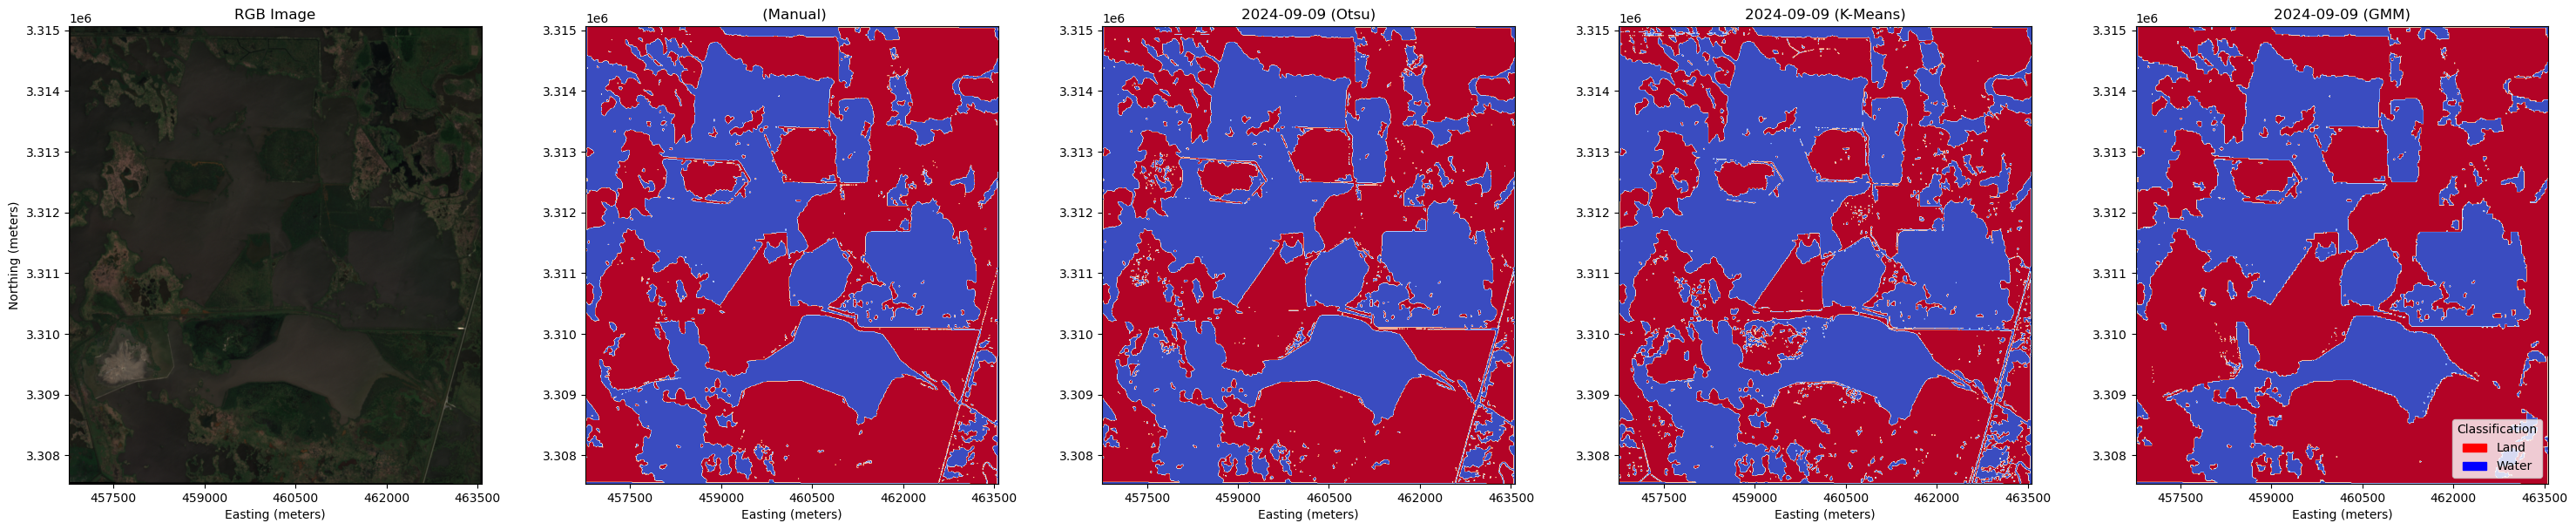

In [161]:
# ndvi, ndwi, msavi2, bsi = map_indices(ind_ims[i])

# from some results, it looks like utilizing the otsu threshold is much 
# more accurate at delineating subaqueous and subaerial land
# a good example is ind_ims[19] thru ind_ims[26]

# classifies land and water
# man_classified, otsu_classified = classify_images(ind_ims[i])

i = 80
plot_class_with_rgb(
    rgb_ims[i], 
    manclasses[i], 
    otsuclasses[i], 
    kmeansclasses[i], 
    gmmclasses[i]
    )

# Label RGB data as Water (0) or Land (1) 

# Export Labeled Sentinel-2 labeled data